# Introduction

In [4]:
## Importing Libraries

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import torch.optim as optim
import lightgbm as lgb
import xgboost

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from numpy import absolute

In [2]:
train = pd.read_csv("data/train.csv")

In [4]:
train

,id,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,0,5,8,5,8,6,4,4,3,3,...,5,3,3,5,4,7,5,7,3,0.445
1,1,6,7,4,4,8,8,3,5,4,...,7,2,0,3,5,3,3,4,3,0.450
2,2,6,5,6,7,3,7,1,5,4,...,7,3,7,5,6,8,2,3,3,0.530
3,3,3,4,6,5,4,8,4,7,6,...,2,4,7,4,4,6,5,7,5,0.535
4,4,5,3,2,6,4,4,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117952,1117952,3,3,4,10,4,5,5,7,10,...,7,8,7,2,2,1,4,6,4,0.495
1117953,1117953,2,2,4,3,9,5,8,1,3,...,9,4,4,3,7,4,9,4,5,0.480
1117954,1117954,7,3,9,4,6,5,9,1,3,...,5,5,5,5,6,5,5,2,4,0.485
1117955,1117955,7,3,3,7,5,2,3,4,6,...,6,8,5,3,4,6,7,6,4,0.495


## Data Preprocessing


### Unique Count

In [5]:
# creating a unique count table
col_name = []
col_count = []
for i in range(1, len(train.columns)):
    col_name.append(train.columns[i])
    col_count.append(train[train.columns[i]].nunique())

unique_count = pd.DataFrame(data={"Name": col_name, "Count": col_count})
unique_count.sort_values(by=unique_count.columns[1])

,Name,Count
0,MonsoonIntensity,17
18,InadequatePlanning,17
14,Watersheds,17
13,Landslides,17
19,PoliticalFactors,17
8,AgriculturalPractices,17
7,Siltation,17
10,IneffectiveDisasterPreparedness,17
2,RiverManagement,17
6,DamsQuality,17


In [6]:
# inspect NA vals
train.isnull().sum()

id                                 0
MonsoonIntensity                   0
TopographyDrainage                 0
RiverManagement                    0
Deforestation                      0
Urbanization                       0
ClimateChange                      0
DamsQuality                        0
Siltation                          0
AgriculturalPractices              0
Encroachments                      0
IneffectiveDisasterPreparedness    0
DrainageSystems                    0
CoastalVulnerability               0
Landslides                         0
Watersheds                         0
DeterioratingInfrastructure        0
PopulationScore                    0
WetlandLoss                        0
InadequatePlanning                 0
PoliticalFactors                   0
FloodProbability                   0
dtype: int64

### Checking for best correlated features

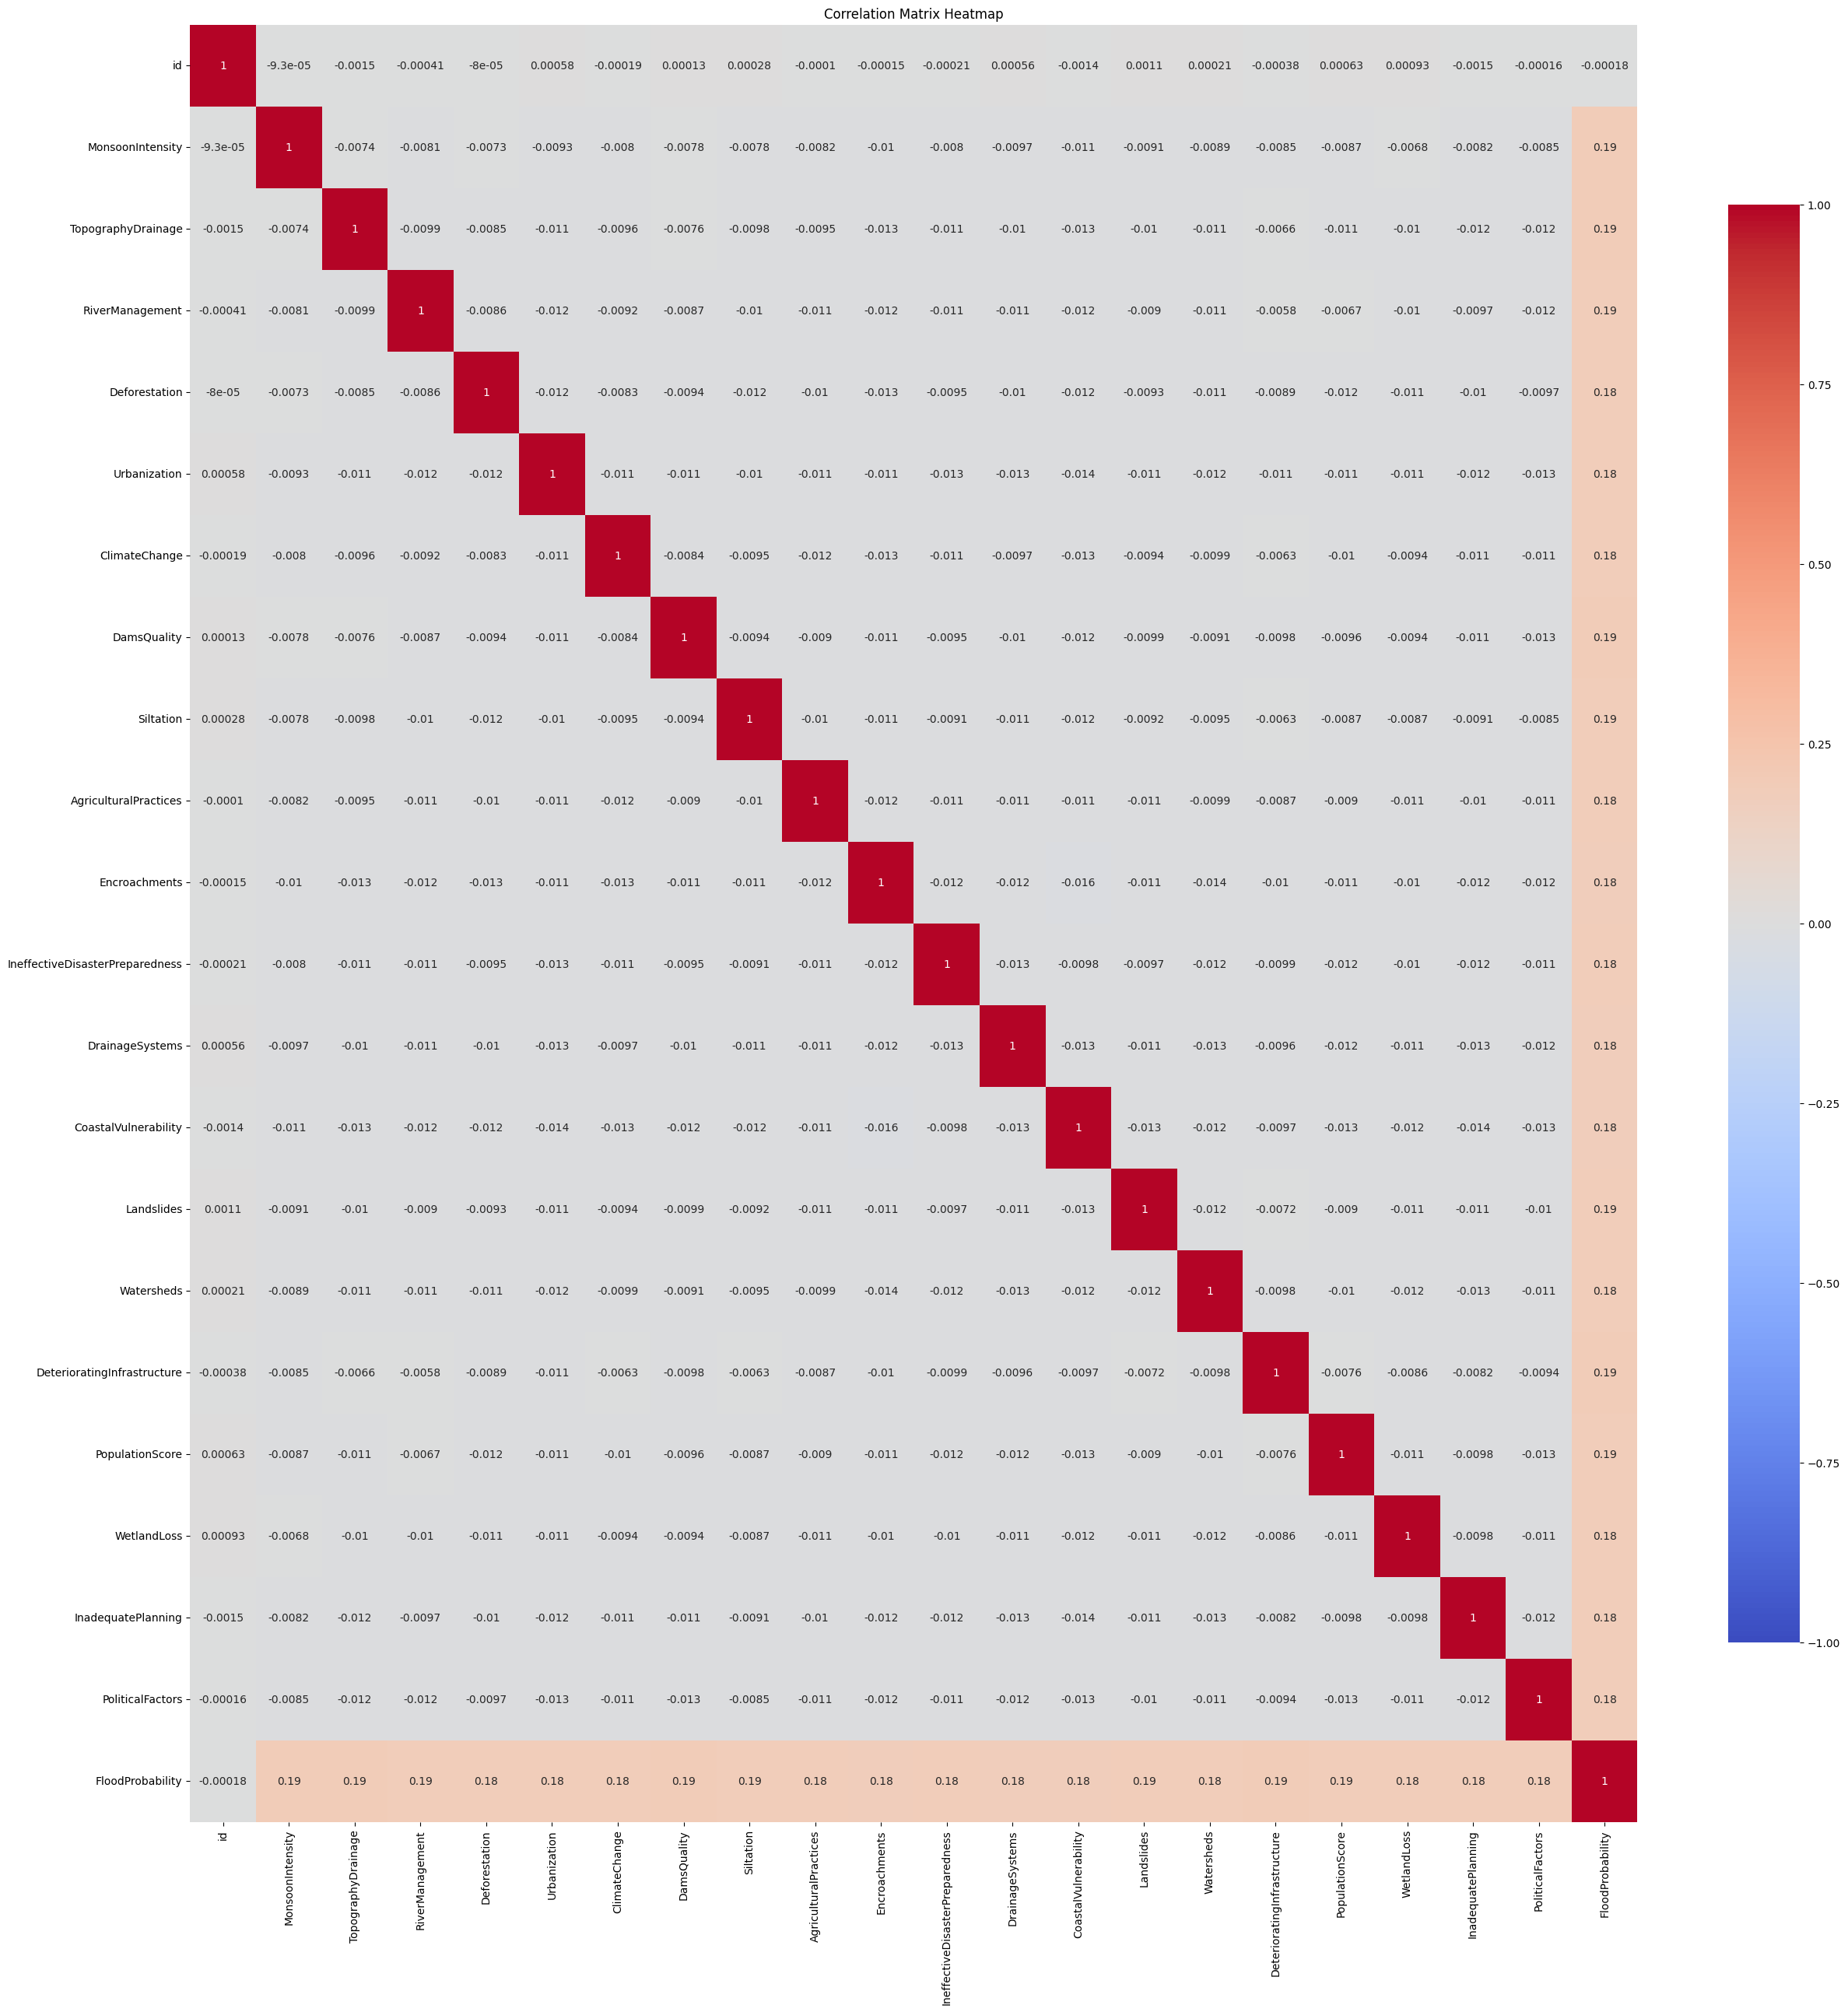

In [7]:
correlation_matrix = train.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    center=0,
    annot_kws={"size": 10},
    cbar_kws={"shrink": 0.8},
)
plt.title("Correlation Matrix Heatmap")
plt.show()

From the above graph, it can be observed that all the variables correlate with the FloodProbability (target variable) strongly with similar correlation values

## Model Building

### Building a XGBRegressor Model

In [3]:
# assigning data and target
target = train["FloodProbability"]
data = train.drop("FloodProbability", axis=1)

X, y = data, target
n_samples, n_features = X.shape

# data splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234
)

In [9]:
# Create a LightGBM dataset for training with features X_train and labels Y_train
train_data = lgb.Dataset(X_train, label=y_train)

# Create a LightGBM dataset for testing with features X_val and labels Y_val,
# and specify the reference dataset as train_data for consistent evaluation
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [5]:
model = xgboost.XGBRegressor(
    n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8
)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(
    model, X, y, scoring="neg_mean_absolute_error", cv=cv, n_jobs=-1
)
# force scores to be positive
scores = absolute(scores)
print("Mean MAE: %.3f (%.3f)" % (scores.mean(), scores.std()))

Mean MAE: 0.016 (0.000)


In [23]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.01, 0.001],
    "subsample": [0.5, 0.7, 1],
}

grid_search_xgb = GridSearchCV(
    model, param_grid, cv=5, scoring="neg_mean_squared_error"
)

# Fit the GridSearchCV object to the training data
grid_search_xgb.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search_xgb.best_params_)
print("Best score: ", grid_search_xgb.best_score_)

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 1}
Best score:  -0.00041218721549357893


In [25]:
import joblib

new_model = xgboost.XGBRegressor(**grid_search_xgb.best_params_)
new_model.fit(X_train, y_train)
joblib.dump(new_model, "new_model.pkl")

['new_model.pkl']

In [6]:
test = pd.read_csv("data/test.csv")

In [8]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [26]:
yhat = new_model.predict(test)

In [16]:
test["id"]

0         1117957
1         1117958
2         1117959
3         1117960
4         1117961
           ...   
745300    1863257
745301    1863258
745302    1863259
745303    1863260
745304    1863261
Name: id, Length: 745305, dtype: int64

In [27]:
yhat
df = pd.DataFrame(yhat, columns=["FloodProbability"])
df1 = pd.merge(test["id"], df, left_index=True, right_index=True)
# df.set_index("id", inplace=True)
df1.to_csv("new_submission.csv", index=False)

In [21]:
df1

,id,FloodProbability
0,1117957,0.579592
1,1117958,0.449599
2,1117959,0.449665
3,1117960,0.466093
4,1117961,0.465690
...,...,...
745300,1863257,0.476682
745301,1863258,0.453114
745302,1863259,0.632383
745303,1863260,0.561670


### Building a Neural Network using Pytorch

#### Building Model Boi